#**Modelo 4: Bayes Naive**

In [ ]:
import pandas as pd
import numpy as np
import joblib
from joblib import dump, load
import sklearn
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, make_scorer)
import tensorflow as tf
from tensorflow import keras
np.random.seed(1)
tf.random.set_seed(1)
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV, train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, classification_report , f1_score, make_scorer, precision_score, recall_score, accuracy_score,f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score


import nltk
nltk.download('stopwords')
stopwords_es = nltk.corpus.stopwords.words('spanish')

import nltk
import string

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_train = pd.read_csv("train_normalizado.csv", engine = "python", error_bad_lines=False)

In [ ]:
df_train.head(5)


,ID,review_es,sentimiento,sentimiento_1
0,0,críticos mencionado después ver solo 1 oz epis...,positivo,1
1,1,pequeña pequeña producción técnica filmación i...,positivo,1
2,2,pensé manera maravillosa pasar tiempo fin sema...,positivo,1
3,3,básicamente familia niño pequeño jake piensa z...,negativo,0
4,4,amor tiempo petter mattei película visualmente...,positivo,1


In [ ]:
def metricas(y_pred,y_test):

  print(classification_report(y_pred,y_test))

  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [ ]:

#Creo un dataset con los features que voy a usar para clasificar
df_train_x = df_train['review_es']

#Creo un dataset con la variable target
df_train_y = df_train['sentimiento_1'].copy()

#Genero los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(df_train_x,
                                                    df_train_y,
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2,
                                                    stratify=df_train_y.values) #semilla

#BAYES NAIVE
Creamos nuestro modelo de bayes primero sin optimizar los hiper parametos

In [ ]:
#Creamos nuestro modelo
Bayes_model = make_pipeline(TfidfVectorizer(), MultinomialNB())
#Entrenamos
Bayes_model.fit(x_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [ ]:
#Predecimos
y_pred_bayes = Bayes_model.predict(x_test)

              precision    recall  f1-score   support

           0       0.90      0.81      0.85      2458
           1       0.78      0.89      0.83      1911

    accuracy                           0.84      4369
   macro avg       0.84      0.85      0.84      4369
weighted avg       0.85      0.84      0.84      4369



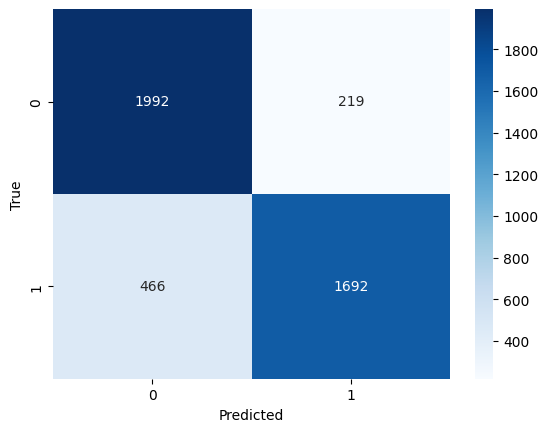

In [ ]:
#Mostramos las metricas
metricas(y_pred_bayes,y_test)

Realizamos las busqueda de hiper parametros

In [ ]:
#Realizamos un TfidVectorizer para pasar tokenizar nuestras criticas
# pipe = make_pipeline(TfidfVectorizer(), MultinomialNB()) #Usamos un make_pipe para pasarle la entrada al segundo modelo

# param_grid = {
#     'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],  # Uni-gram, bi-gram, or tri-gram
#     'multinomialnb__alpha': [0.01, 0.1, 0.5, 1.0],  # Smoothing parameter
# }

# # Grid search
# grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1')
# grid_search.fit(x_train, y_train)
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_
# display(best_params)
# display(best_score)

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score

# Realizamos un TfidfVectorizer para tokenizar nuestras críticas
pipe = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Parámetros a buscar
param_grid = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidfvectorizer__max_features': [500, 1000, 2000, None],
    'tfidfvectorizer__stop_words': [None, 'english', custom_stop_words_list],
    'multinomialnb__alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
}

# Validación cruzada estratificada
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Métricas a evaluar
scoring_metrics = ['f1', 'precision', 'recall']

# Búsqueda de hiperparámetros
grid_search = GridSearchCV(pipe, param_grid, cv=cv_stratified, scoring=scoring_metrics, n_jobs=-1, refit='f1')
grid_search.fit(x_train, y_train)

# Mejores parámetros y puntuación
best_params = grid_search.best_params_
best_scores = {metric: grid_search.cv_results_['mean_test_' + metric][grid_search.best_index_] for metric in scoring_metrics}

# Mostrar resultados
display(best_params)
display(best_scores)

{'multinomialnb__alpha': 0.1, 'tfidfvectorizer__ngram_range': (1, 3)}

0.8441959738805412

In [ ]:
nb_model_h = make_pipeline(TfidfVectorizer(ngram_range =(1, 2)), MultinomialNB(alpha = 0.2))


In [ ]:
#Entrenamos el modelo
nb_model_h.fit(x_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('multinomialnb', MultinomialNB(alpha=0.2))])

In [ ]:
y_pred_h = nb_model_h.predict(x_test)

              precision    recall  f1-score   support

           0       0.91      0.84      0.87      2378
           1       0.83      0.90      0.86      1991

    accuracy                           0.87      4369
   macro avg       0.87      0.87      0.87      4369
weighted avg       0.87      0.87      0.87      4369



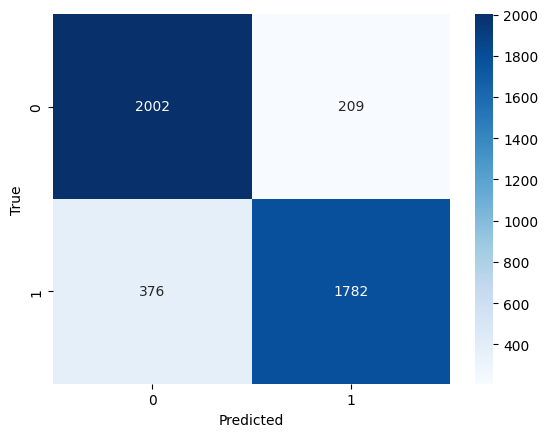

In [ ]:
metricas(y_pred_h,y_test)

##Preprosesamiento de Test

In [ ]:
df_test  = pd.read_csv("test_normalizado.csv", engine="python")
df_copy_id_test = df_test['ID'] #copio el id y lo quito del dataframe
df_test.drop(['ID'], axis='columns', inplace=True)
df_test.head(5)

,review_es
0,mayor virtud película existencia hecho podamos...
1,experto cinéfilo pocas veces tan juego sala ci...
2,si incondicional humor estilo tele 5 si termin...
3,sé pasando si gente deja llevar modas si verda...
4,"amanece,y quedo solo,siento fondoun mar vacío,..."


# Submit Bayes naive


In [ ]:
y_submit = nb_model_h.predict(df_test['review_es'])

In [ ]:
df_submit_test = pd.DataFrame({'ID': df_copy_id_test,'sentimiento':y_submit})
df_submit_test['sentimiento'] = np.where(df_submit_test['sentimiento'] == 1, 'positivo', 'negativo')

df_submit_test.to_csv('Submit_test.csv',index = False)